In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()
#gec.load_gp_datas("./gp_datas.json")


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]
np.random.seed(101)
ind = np.random.uniform(0, 1, X.shape[0]) <0.5
X = X[ind,:]
y = y[ind]

X_pos = X[y==1,:]
y_pos = y[y==1]

X_reweighted = np.concatenate([X] + [X_pos]*3, axis=0)
y_reweighted = np.concatenate([y] + [y_pos]*3)


print(X_reweighted.shape)

(30488, 48)


/tmp/ipykernel_35938/1527586109.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_35938/1527586109.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [3]:
gec.fit(X_reweighted, y_reweighted, 100)

 57%|█████▋    | 57/100 [01:43<01:59,  2.77s/it]/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 59%|█████▉    | 59/100 [01:45<01:17,  1.89s/it]/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 61%|██████    | 61/100 [01:46<00:47,  1.21s/it]/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning

GEC(random_state=101)

In [4]:
gec.best_scores_gec

{'search': 0.7209037367160124,
 'grid': 0.5856367845849838,
 'grid_from_search': 0.6695709763564004}

In [5]:
gec.best_params_gec

{'search': {'boosting': 'dart',
  'num_leaves': 142,
  'learning_rate': 0.15421531907756736,
  'n_estimators': 30,
  'max_bin': 90,
  'max_depth': 10,
  'lambda_l1': 0.6031192352538136,
  'lambda_l2': 0.855276669575315,
  'min_data_in_leaf': 48,
  'feature_fraction': 0.12,
  'bagging_freq': 8,
  'bagging_fraction': 0.1,
  'verbosity': -1},
 'grid': {'boosting': 'dart',
  'num_leaves': 97,
  'learning_rate': 0.026517764705139425,
  'n_estimators': 50,
  'max_bin': 350,
  'max_depth': 70,
  'lambda_l1': 0.2700521429238798,
  'lambda_l2': 0.2975977524254038,
  'min_data_in_leaf': 30,
  'feature_fraction': 0.47999999999999976,
  'bagging_freq': 1,
  'bagging_fraction': 0.6500000000000001},
 'grid_from_search': {'boosting': 'dart',
  'num_leaves': 136,
  'learning_rate': 0.13420388885841905,
  'n_estimators': 20,
  'max_bin': 140,
  'max_depth': 40,
  'lambda_l1': 0.5396689797840741,
  'lambda_l2': 0.7294036972829212,
  'min_data_in_leaf': 42,
  'feature_fraction': 0.14999999999999997,
  'b

In [6]:
gec.rewards

{'gbdt-yes_bagging': {'a': 1.2977222341890298, 'b': 1.428631153179362},
 'gbdt-no_bagging': {'a': 1.3379183463581548, 'b': 1.2529266623265984},
 'dart-yes_bagging': {'a': 1.567845964094968, 'b': 1.3415194076370163},
 'dart-no_bagging': {'a': 1.1047397376189356, 'b': 1.4687177308113015},
 'rf-yes_bagging': {'a': 1.5403060953405625, 'b': 1.3001195387582847}}

In [7]:
print({k:(np.mean(v["output"]), np.max(v["output"]), len(v["output"])) for k, v in gec.gp_datas.items()})

{'gbdt-yes_bagging': (0.620237683190818, 0.6667198733981247, 14), 'gbdt-no_bagging': (0.6333707290963113, 0.6704866098199944, 20), 'dart-yes_bagging': (0.650495183570652, 0.7209037367160124, 26), 'dart-no_bagging': (0.6190916512479161, 0.676494884352708, 17), 'rf-yes_bagging': (0.6415715149970417, 0.7049938879553962, 23)}


/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


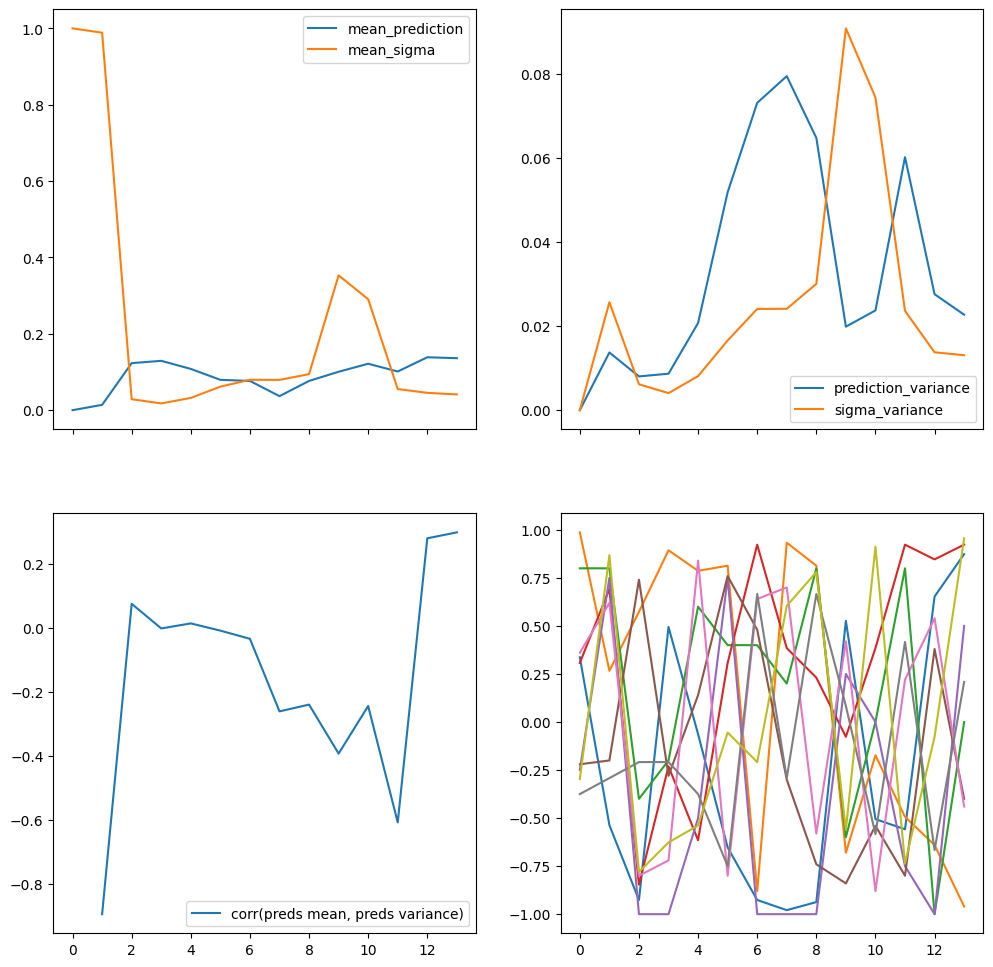

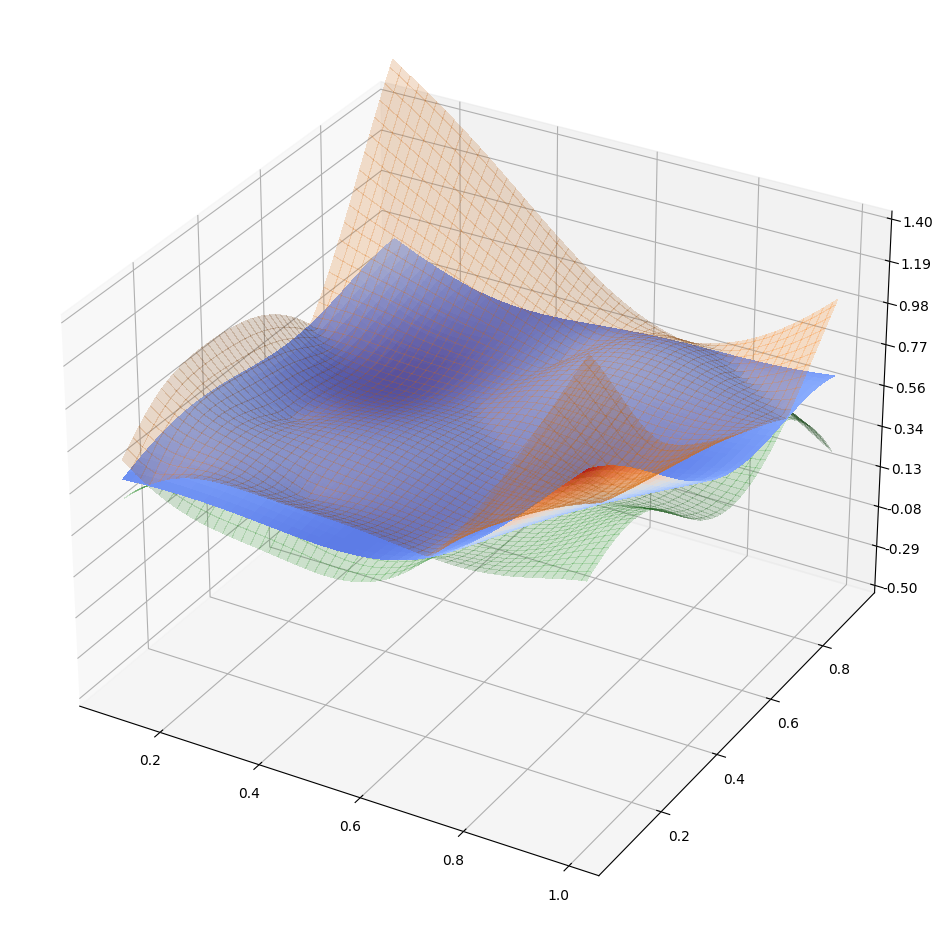

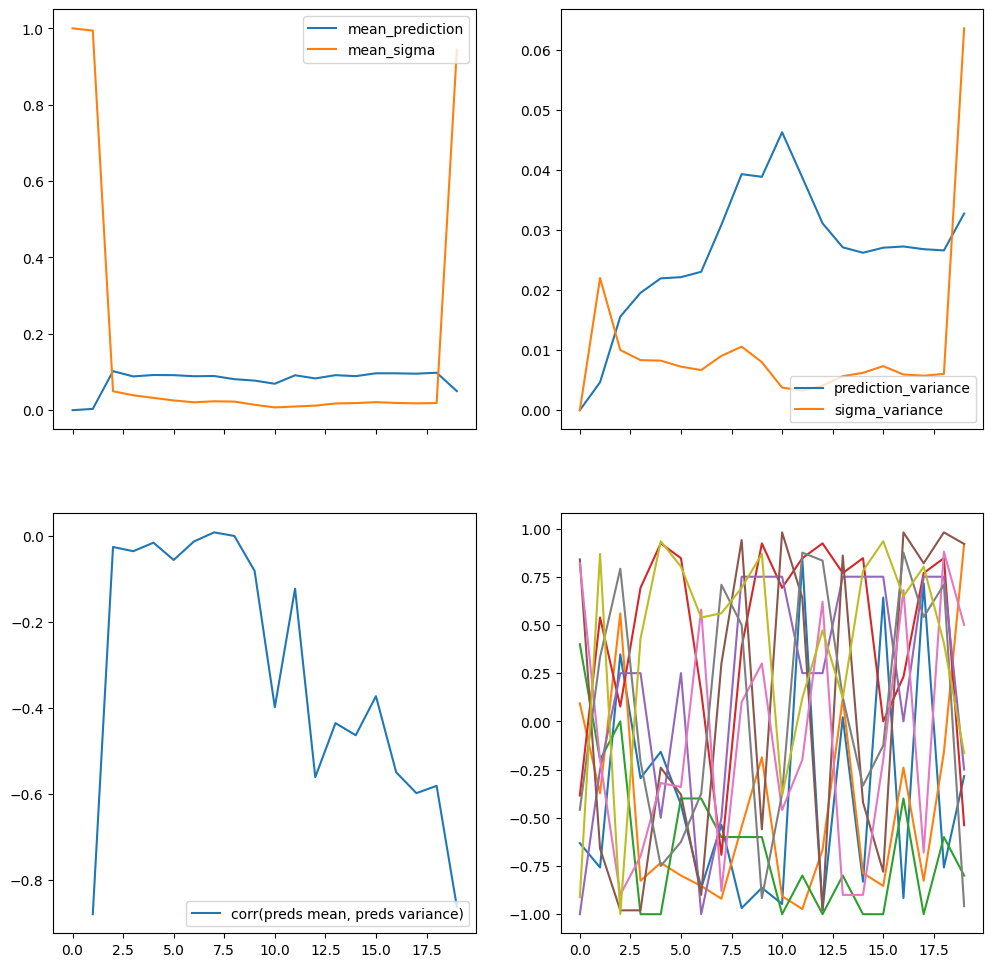

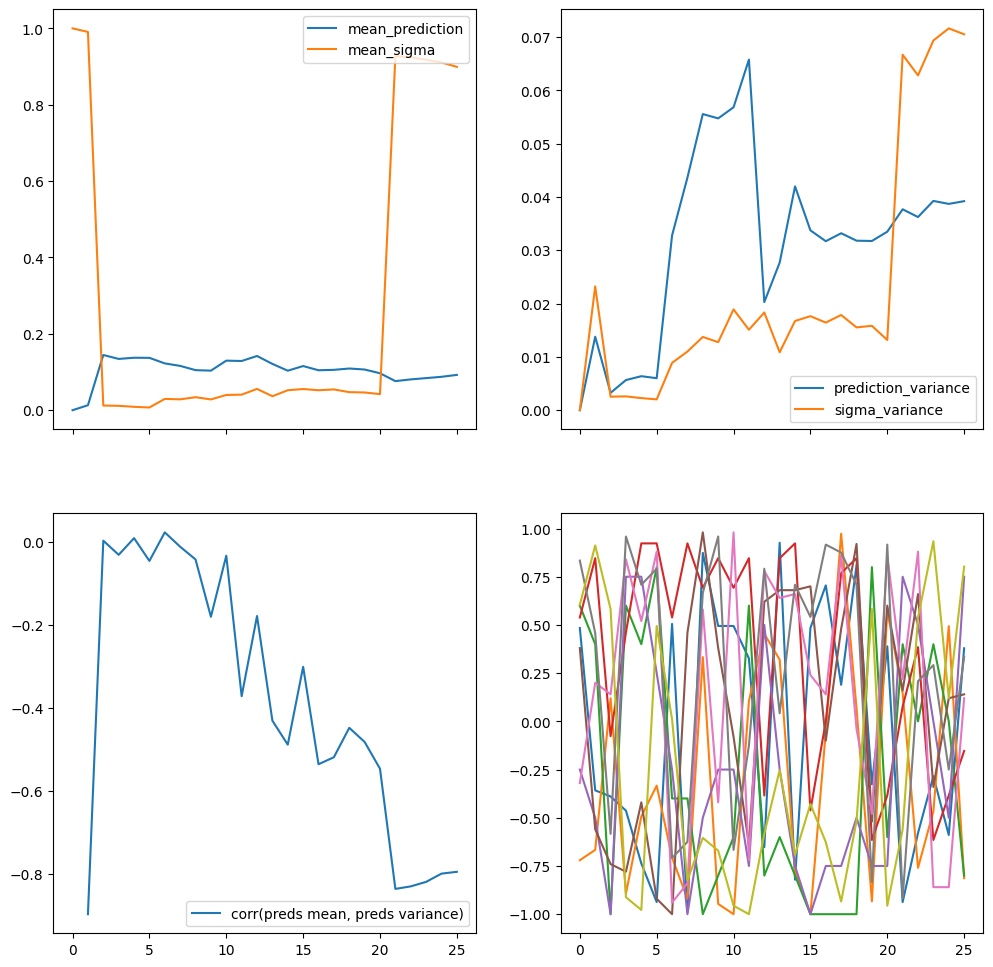

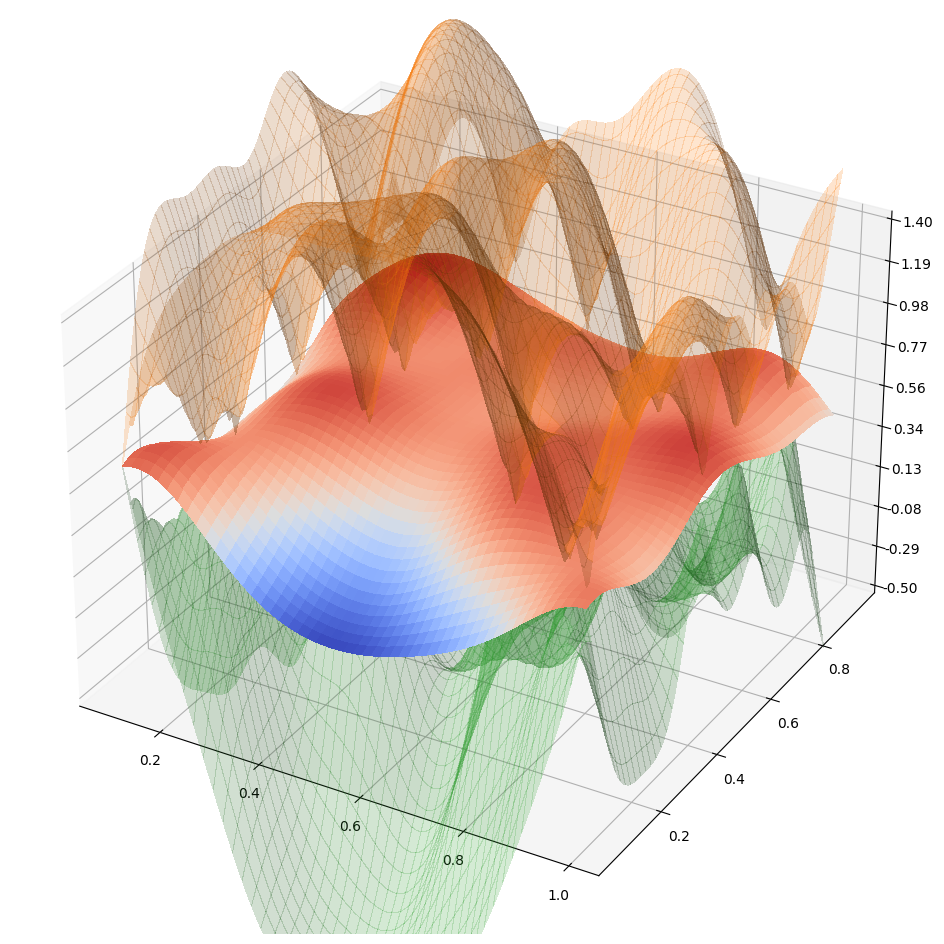

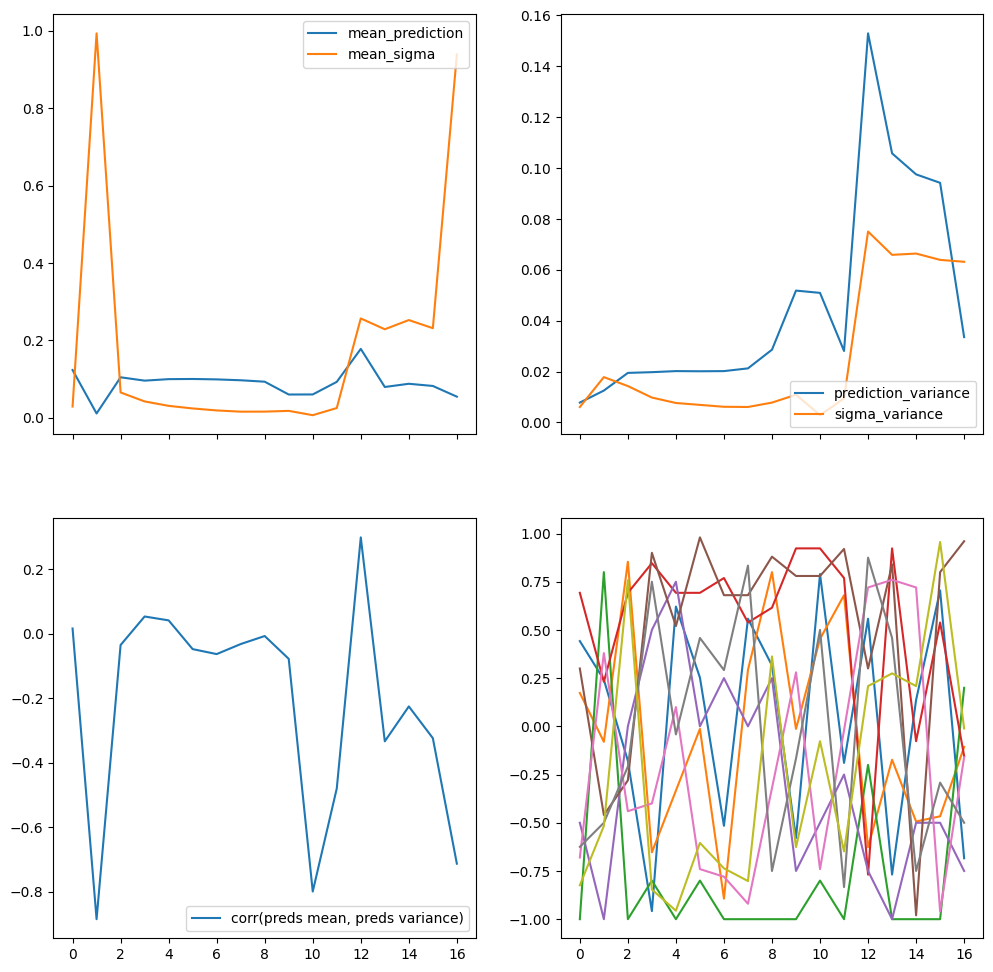

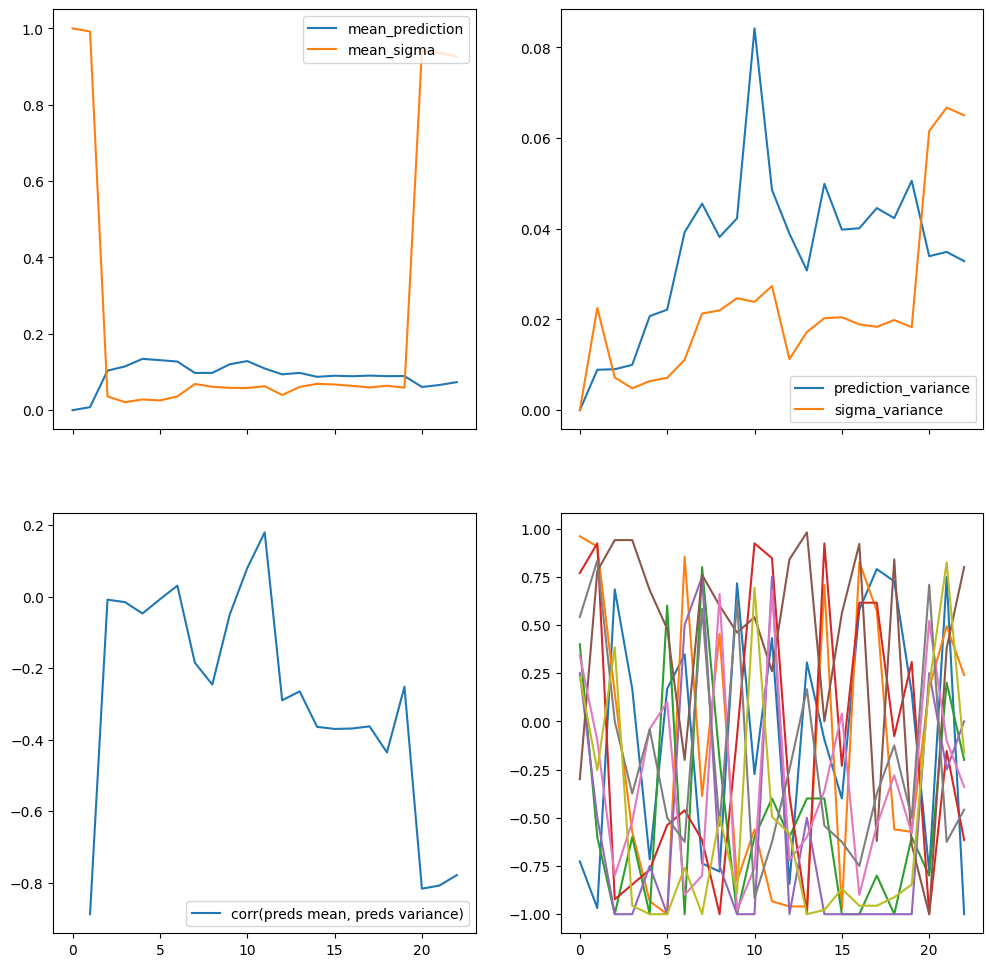

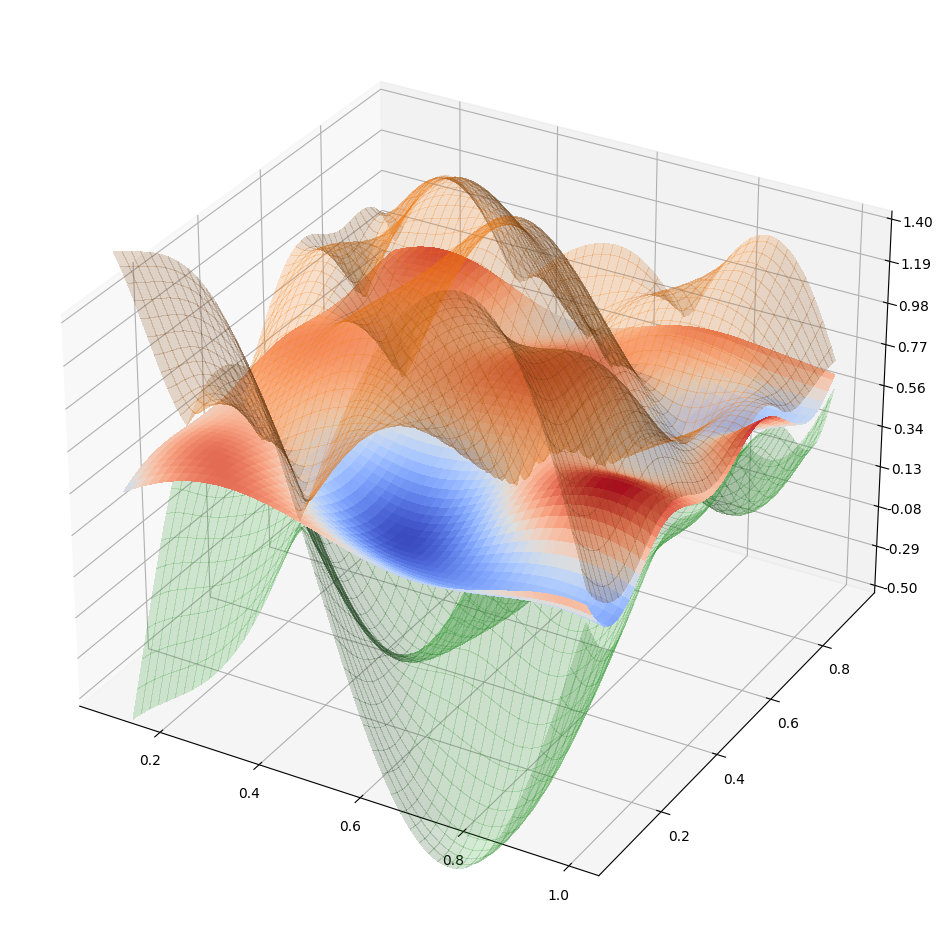

In [8]:
gec.save_figs("./test")

In [ ]:
bayesian_params = gec.best_params_gec["grid"]
print(bayesian_params)
clf_bayes = LGBMClassifier(**bayesian_params)
score_bayes = np.mean(cross_val_score(clf_bayes, X_reweighted, y_reweighted, cv=5))
score_bayes

In [ ]:
clf_default = LGBMClassifier()
score_default = np.mean(cross_val_score(clf_default, X_reweighted, y_reweighted, cv=5))
score_default

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'rf', 'num_leaves': 199, 'learning_rate': 0.010023052380778996, 'n_estimators': 10, 'max_bin': 140, 'max_depth': 400, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 49, 'feature_fraction': 1.0, 'bagging_freq': 1, 'bagging_fraction': 0.05})
score_bayes = np.mean(cross_val_score(knn_bayes, X_reweighted, y_reweighted, cv=5))
score_bayes

In [ ]:
gec.categorical_hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.categorical_hyperparameters[:1] + gec.real_hyperparameters)
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=10)
gs.fit(X_reweighted, y_reweighted)

In [ ]:
X_eval, y_eval = X_reweighted, y_reweighted
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X_eval, y_eval, cv=5))
knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X_eval, y_eval, cv=5))
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X_eval, y_eval, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=gec.kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gec.bagging_datas["gbdt-yes_bagging"]["inputs"], gec.bagging_datas["gbdt-yes_bagging"]["output"])

In [ ]:
import matplotlib.pyplot as plt
def summarise_gp_datas():

    figs = {}

    for categorical_combination in gec.categorical_hyperparameter_combinations:
        fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(12,12))
        ax1, ax2, ax3, ax4 = axes.flatten()

        x = np.arange(len(gec.gp_datas[categorical_combination]["means"]))
        gec.plot_mean_prediction_and_mean_variance(categorical_combination, ax1, x)
        gec.plot_prediction_std_and_variance_std(categorical_combination, ax2, x)
        gec.plot_prediction_mean_variance_correlation(
            categorical_combination, ax3, x
        )
        gec.plot_linear_scaled_parameter_samples(categorical_combination, ax4, x)

        figs[categorical_combination] = fig

        if "yes_bagging" in categorical_combination:
            fig2 = plot_boosting_parameter_surface(categorical_combination)
            figs[f"{categorical_combination}_bagging"] = fig2
            

    return figs

In [ ]:
summarise_gp_datas()

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'gbdt', 'lambda_l1': 0.46, 'num_leaves': 12})
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes